In [1]:
# !pip install spacy
import spacy
import numpy as np
import re
import pandas as pd
import os

In [2]:
nlp = spacy.load('en_core_web_sm')

In [3]:
pasta = [r"output", r"output-2", r"output-3", r"output-4", r"output-5"]

dataframes = []

for p in pasta:
    for arquivo in os.listdir(p):
        caminho_arquivo = os.path.join(p, arquivo)
        df = pd.read_json(caminho_arquivo)
        df['Arquivo_origem'] = arquivo
        dataframes.append(df)

In [4]:
df= pd.concat(dataframes, ignore_index=True)
df = df.rename(columns={0: 'ion name', 
                                    1: 'ion formula',
                                    2: 'material type', 
                                    3: 'material composition', 
                                    4: 'max adsorption',
                                    5: 'efficiency'})

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 556 entries, 0 to 555
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ion name              555 non-null    object
 1   ion formula           555 non-null    object
 2   material type         556 non-null    object
 3   material composition  556 non-null    object
 4   max adsorption        553 non-null    object
 5   efficiency            553 non-null    object
 6   Arquivo_origem        556 non-null    object
dtypes: object(7)
memory usage: 30.5+ KB


In [5]:
# Remover linhas com None
df = df.dropna()
df = df[~df['max adsorption'].isin(['None'])]
df = df[~df['ion formula'].isin(['None'])]

df = df.reset_index(drop=True)

df

,ion name,ion formula,material type,material composition,max adsorption,efficiency,Arquivo_origem
0,Cadmium,Cd(II),hydrogel,xanthan gum-cl-poly(acrylamide-co-alginic acid...,125 mg · g⁻¹,None,resultado_10.json
1,Cadmium,Cd(II),aerogel,carbon aerogel,15.53 mg g(-1),None,resultado_11.json
2,Cadmium,Cd(II),cryogel,poly(hydroxyethyl methacrylate N-methacryloly-...,76.35 μ mol/g,98.8 %,resultado_2.json
3,Cadmium,Cd(II),cryogel,poly(hydroxyethyl methacrylate N-methacryloly-...,98.8 μ mol/g,98.8 %,resultado_2.json
4,Lead,Pb(II),aerogel,silica aerogels modified with amino propyl tri...,45.45mg/g,None,resultado_20.json
...,...,...,...,...,...,...,...
300,Cobalt,Co(II),None,polysaccharide from Artemisia vulgaris modifie...,170.7 mg/g,None,resultado_8.json
301,Copper,Cu(II),membrane,PVDF/G3.0 PAMAM-Pal,155.19 mg/g,None,resultado_9.json
302,Nickel,Ni(II),membrane,PVDF/G3.0 PAMAM-Pal,124.28 mg/g,None,resultado_9.json
303,Cadmium,Cd(II),membrane,PVDF/G3.0 PAMAM-Pal,125.55 mg/g,None,resultado_9.json


In [6]:
comp = []

for material in df['material composition']:
    abs = []

    doc = nlp(material)

    filtered_words = [token.text.lower() for token in doc]

    abs.append(' '.join(filtered_words))

    comp.append(abs[0])


In [7]:
roman_to_num = {
    'I': '1',
    'II': '2+',
    'III': '3+',
    'IV': '4+',
    'V': '5+',
    'VI': '6+'
}

# Função para extrair nome e estado de oxidação
def extract_ion_parts(formula):
    """
    Extrai o elemento químico e o estado de oxidação, tanto no formato Cd(II)
    quanto Cd2+, retornando (elemento, estado).
    """
    match = re.match(r'([A-Z][a-z]?)(?:\(([^)]+)\)|(\d+[+-]?))?', formula)
    if match:
        ion = match.group(1)
        ox_state = match.group(2) or match.group(3)
        return ion, ox_state
    return None, None

# Aplicar a função
df[['ion', 'oxidation_state']] = df['ion formula'].apply(lambda x: pd.Series(extract_ion_parts(x)))

df['oxidation_state'] = df['oxidation_state'].map(roman_to_num)

In [8]:
# Função para extrair o valor numérico e a unidade
def split_value_unit(text):
    if pd.isna(text):
        return None, None
    
    # Corrigir caracteres estranhos e espaços
    t = str(text).replace('·', '').replace('⁻¹', '-1').replace('−', '-').replace(' ', '')
    
    # Regex para separar número e unidade
    match = re.match(r"([-+]?\d*\.?\d+)\s*([a-zA-Zμ^/().-]*)", t)
    if match:
        value = float(match.group(1))
        unit = match.group(2)
        return value, unit
    else:
        return None, None

# Aplicar
df[['value', 'unit']] = df['max adsorption'].apply(lambda x: pd.Series(split_value_unit(x)))

In [9]:
from sentence_transformers import SentenceTransformer

# Carregar modelo (escolha um modelo conforme trade-off entre precisão e velocidade)
model = SentenceTransformer('all-mpnet-base-v2')  # ótimo equilíbrio

# Gerar embeddings (matriz N x D)
embeddings = model.encode(comp, show_progress_bar=True, convert_to_numpy=True)

# Inserir no dataframe (opcional) e salvar
df['comp_embedding'] = list(embeddings.astype(float))      # cada célula contém um vetor numpy
np.save('embeddings.npy', embeddings)   # salvar matriz de embeddings

print("Shape dos embeddings:", embeddings.shape)  # (n_documents, dim)

C:\Users\Ana Clara Brandão\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Batches: 100%|██████████| 10/10 [00:22<00:00,  2.29s/it]

Shape dos embeddings: (305, 768)


In [10]:
# Gerar embeddings (matriz N x D)
embeddings = model.encode(df['ion'].tolist(), show_progress_bar=True, convert_to_numpy=True)

# Inserir no dataframe (opcional) e salvar
df['ion_embedding'] = list(embeddings.astype(float))      # cada célula contém um vetor numpy
np.save('embeddings.npy', embeddings)   # salvar matriz de embeddings

print("Shape dos embeddings:", embeddings.shape)  # (n_documents, dim)

Batches: 100%|██████████| 10/10 [00:04<00:00,  2.04it/s]

Shape dos embeddings: (305, 768)


In [11]:
# Gerar embeddings (matriz N x D)
embeddings = model.encode(df['material type'].tolist(), show_progress_bar=True, convert_to_numpy=True)

# Inserir no dataframe (opcional) e salvar
df['material_embedding'] = list(embeddings.astype(float))      # cada célula contém um vetor numpy
np.save('embeddings.npy', embeddings)   # salvar matriz de embeddings

print("Shape dos embeddings:", embeddings.shape)  # (n_documents, dim)

Batches: 100%|██████████| 10/10 [00:04<00:00,  2.34it/s]

Shape dos embeddings: (305, 768)


C:\Users\Ana Clara Brandão\AppData\Local\Temp\ipykernel_8844\1744121467.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


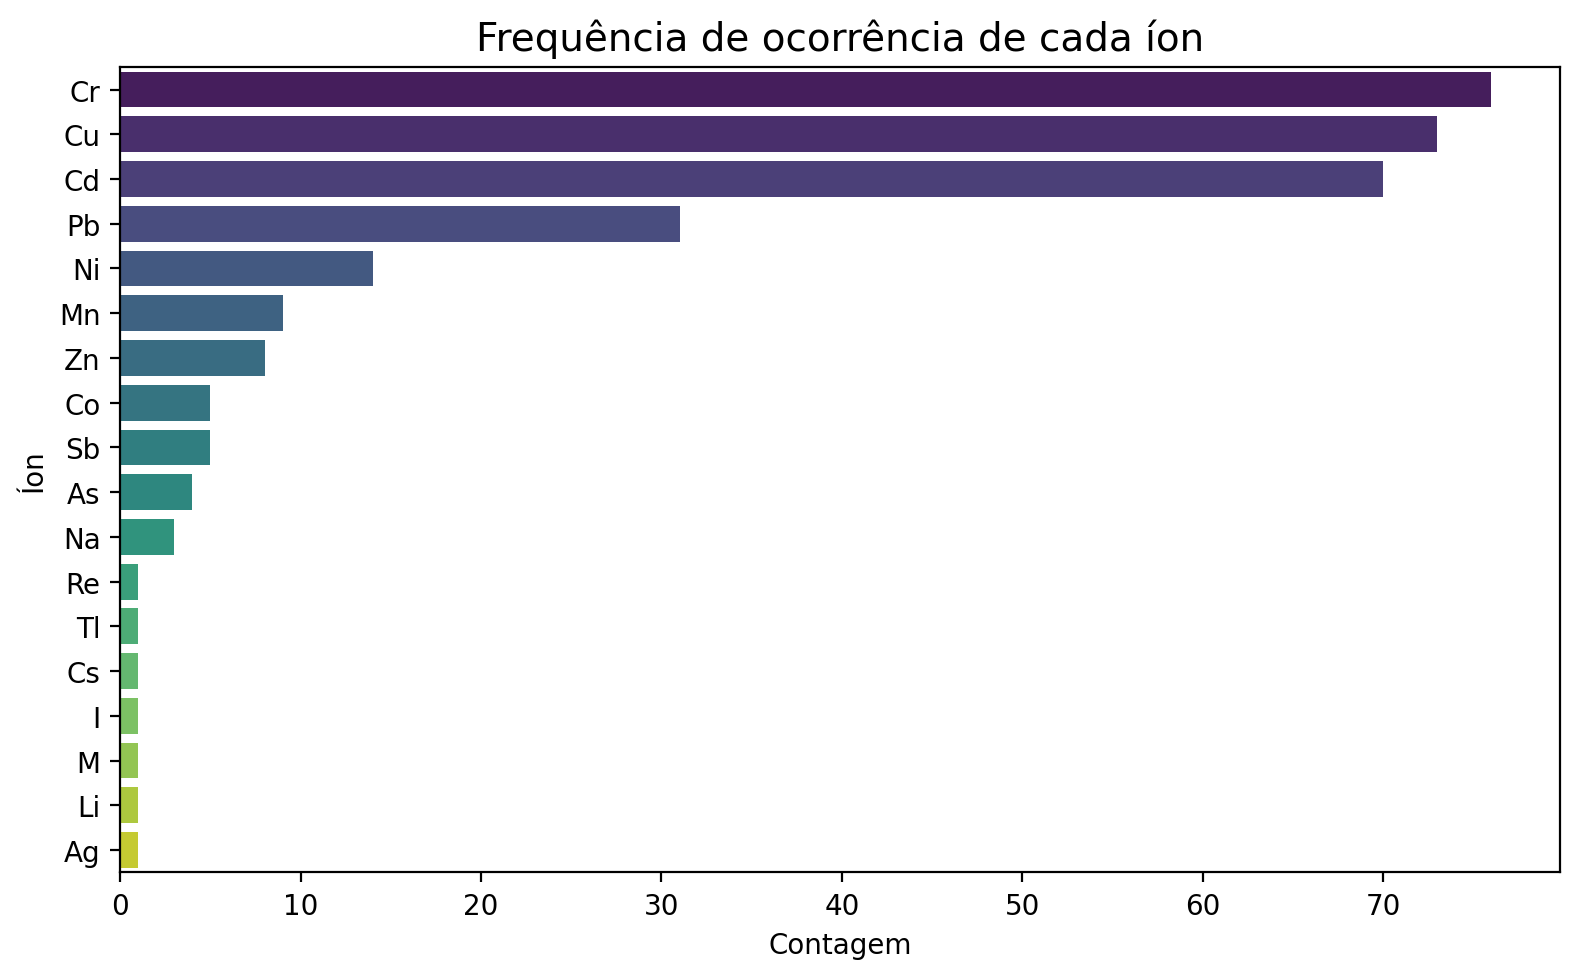

C:\Users\Ana Clara Brandão\AppData\Local\Temp\ipykernel_8844\1744121467.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


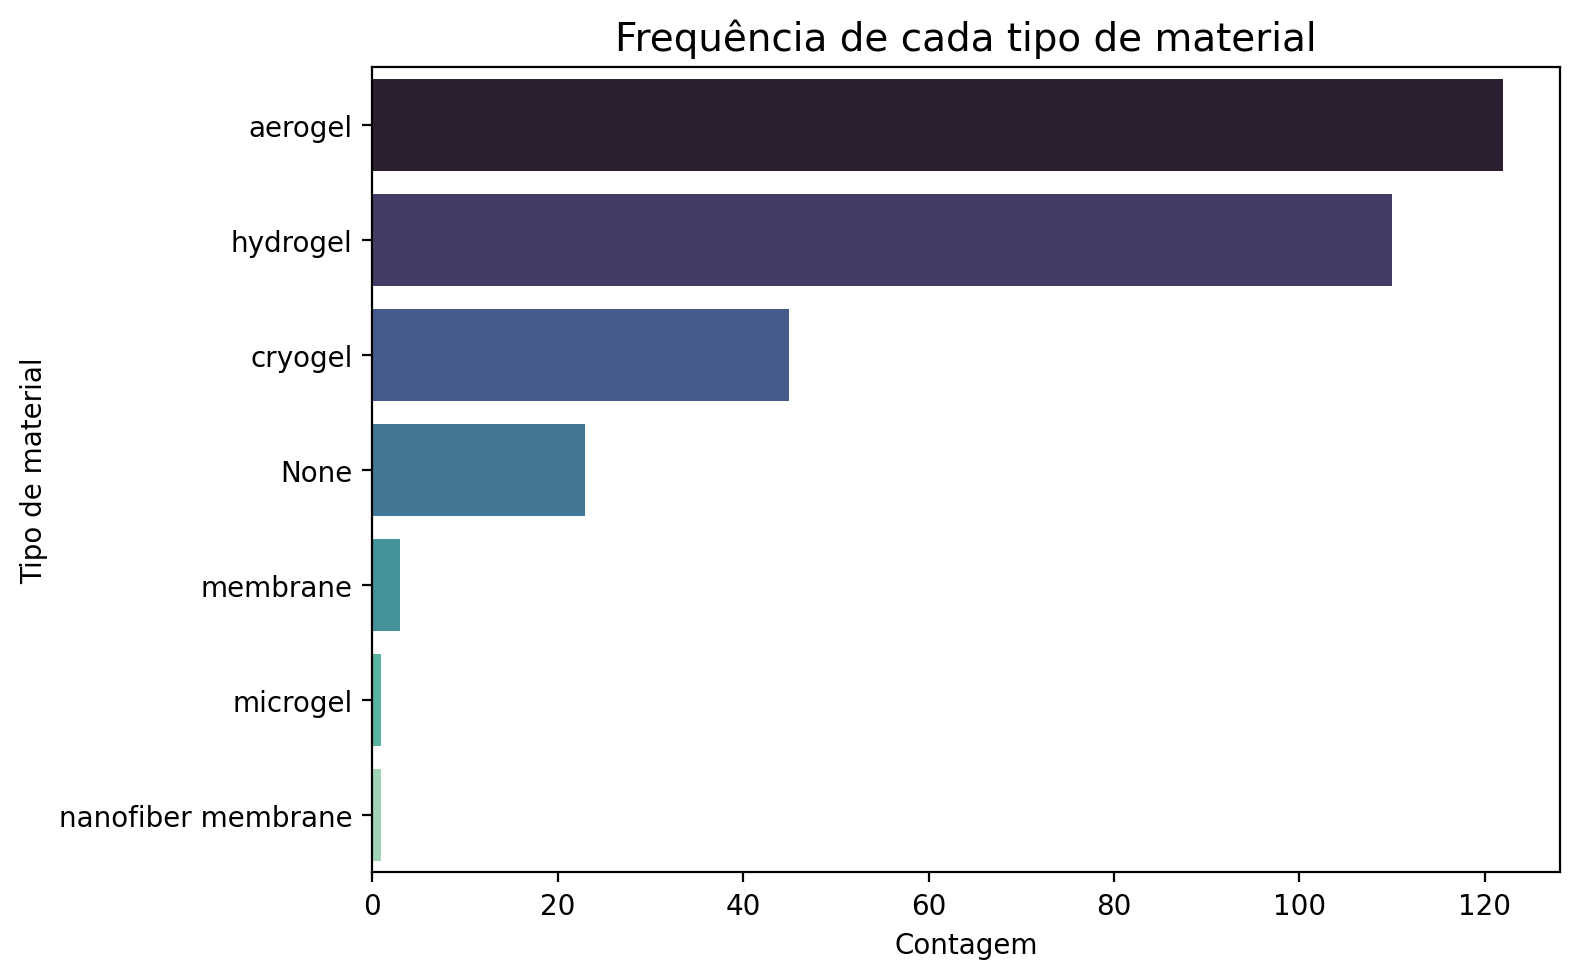

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(8, 5), dpi=200)
sns.countplot(
    y='ion', 
    data=df, 
    order=df['ion'].value_counts().index, 
    palette='viridis'
)
plt.title('Frequência de ocorrência de cada íon', fontsize=14)
plt.xlabel('Contagem')
plt.ylabel('Íon')
plt.tight_layout()
plt.show()


plt.figure(figsize=(8, 5), dpi=200)
sns.countplot(
    y='material type', 
    data=df, 
    order=df['material type'].value_counts().index, 
    palette='mako'
)
plt.title('Frequência de cada tipo de material', fontsize=14)
plt.xlabel('Contagem')
plt.ylabel('Tipo de material')
plt.tight_layout()
plt.show()


In [13]:
df = pd.read_excel("df_embending.xlsx")

# Converter todas as composições para minúsculas
df['material composition'] = df['material composition'].astype(str).str.lower()

# Listar palavras mais comuns para ter uma ideia dos polímeros
from collections import Counter
from itertools import chain

words = chain.from_iterable(df['material composition'].str.split())
common = Counter(words).most_common(50)
for w, c in common:
    print(f"{w:<20} {c}")


and                  47
aerogel              41
modified             27
cellulose            26
acid                 24
with                 22
sodium               22
composite            21
alginate             20
methacrylate)        18
graphene             18
oxide                17
chitosan             17
hydrogel             16
carbon               13
poly(vim)/mfc        12
xylan                12
hemicellulose        12
groups,              12
poly(hydroxyethyl    10
silica               10
immobilized          9
of                   9
carboxymethyl        9
nanocellulose        9
triethoxysilane      8
poly-l-histidine     8
poly(glycidyl        8
cross-linked         8
polyethyleneimine    8
cryogel              7
(sa),                7
organic              7
(aa)                 7
hyperbranched        6
fe3o4                6
grafted              6
(pei)                6
magnetic             6
nanofiber            6
acrylamide           6
(sulfonic            6
(sulfonate   

In [14]:
def classify_polymer(comp):
    comp = str(comp).lower()
    if 'cellulose' in comp:
        return 'Cellulose-based'
    elif 'chitosan' in comp or 'chitin' in comp:
        return 'Chitosan-based'
    elif 'alginate' in comp or 'alginic' in comp:
        return 'Alginate-based'
    elif 'starch' in comp:
        return 'Starch-based'
    elif 'pectin' in comp:
        return 'Pectin-based'
    elif 'collagen' in comp:
        return 'Collagen-based'
    elif 'lignin' in comp:
        return 'Lignin-based'
    elif 'carbon' in comp or 'biochar' in comp:
        return 'Carbon-based'
    else:
        return 'Other / Synthetic'

df['polymer_group'] = df['material composition'].apply(classify_polymer)

# Verificar distribuição
print(df['polymer_group'].value_counts())


polymer_group
Other / Synthetic    162
Cellulose-based       63
Alginate-based        34
Chitosan-based        34
Carbon-based           7
Lignin-based           4
Starch-based           1
Name: count, dtype: int64


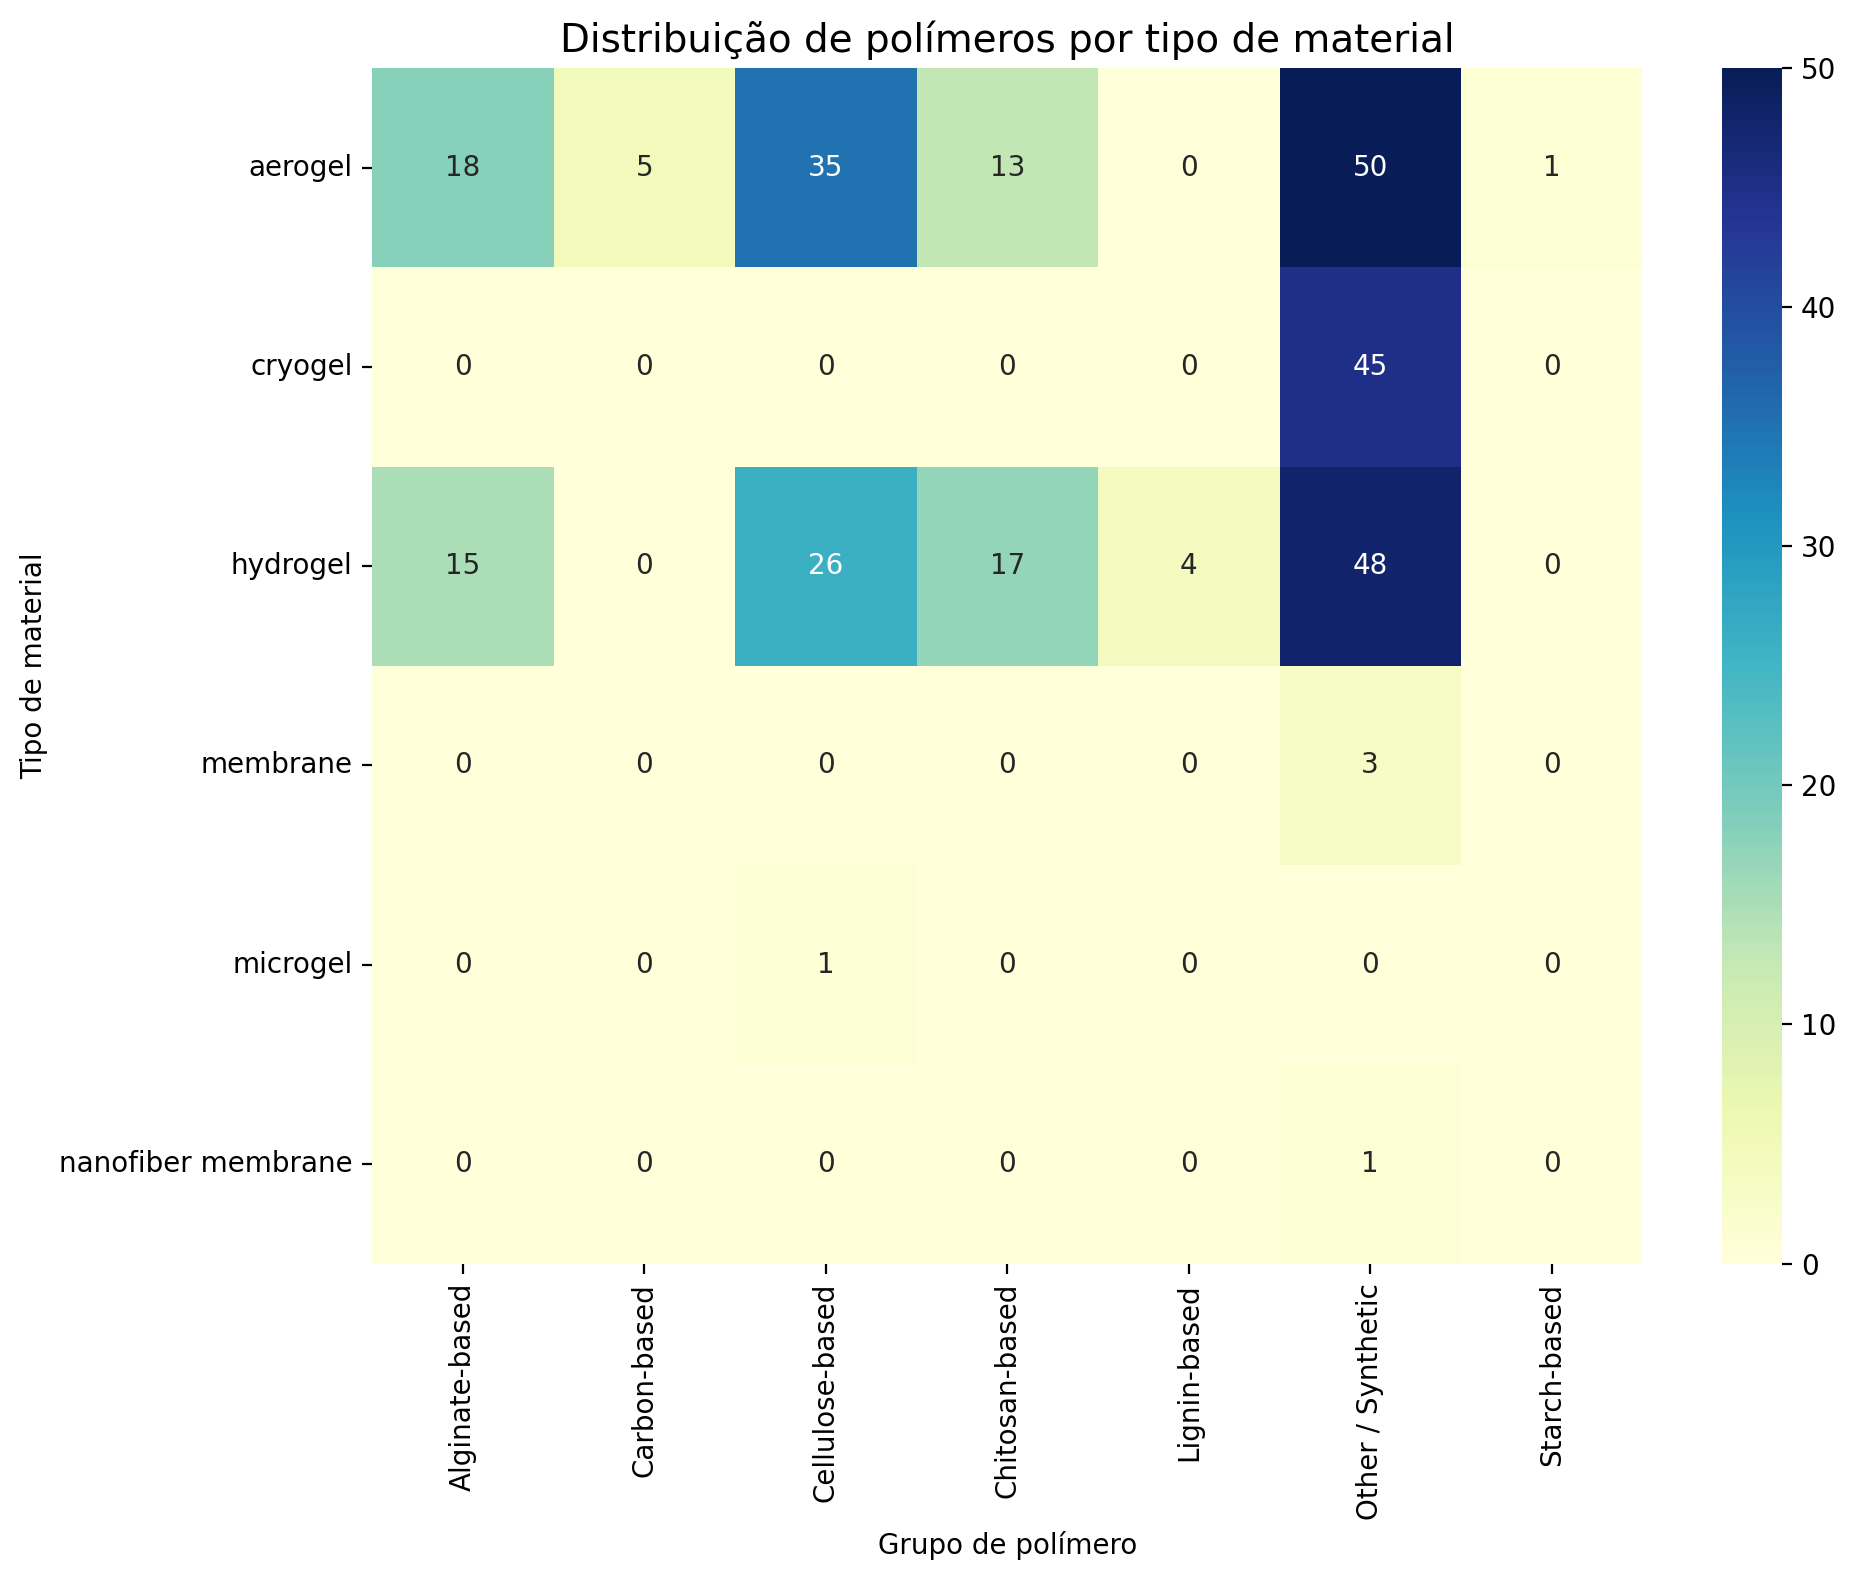

In [15]:
plt.figure(figsize=(10, 8), dpi=200)
pivot = pd.crosstab(df['material type'], df['polymer_group'])
sns.heatmap(pivot, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Distribuição de polímeros por tipo de material', fontsize=14)
plt.xlabel('Grupo de polímero')
plt.ylabel('Tipo de material')
plt.tight_layout()
plt.show()

In [16]:
# Garantir lowercase e limpar espaços
df['material composition'] = df['material composition'].astype(str).str.lower().str.strip()
df['material type'] = df['material type'].astype(str).str.lower().str.strip()
df['ion'] = df['ion'].astype(str).str.replace(" ", "").str.strip()


df['polymer_group'] = df['material composition'].apply(classify_polymer)

# Verificar distribuição
print(df['polymer_group'].value_counts())

# Contagem de combinações
combo_counts = (
    df.groupby(['polymer_group', 'material type', 'ion'])
      .size()
      .reset_index(name='count')
)

combo_counts.head()


polymer_group
Other / Synthetic    162
Cellulose-based       63
Alginate-based        34
Chitosan-based        34
Carbon-based           7
Lignin-based           4
Starch-based           1
Name: count, dtype: int64


,polymer_group,material type,ion,count
0,Alginate-based,aerogel,Cd,6
1,Alginate-based,aerogel,Cr,5
2,Alginate-based,aerogel,Cu,6
3,Alginate-based,aerogel,Pb,1
4,Alginate-based,hydrogel,Cd,6


C:\Users\Ana Clara Brandão\AppData\Local\Temp\ipykernel_8844\635958612.py:30: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


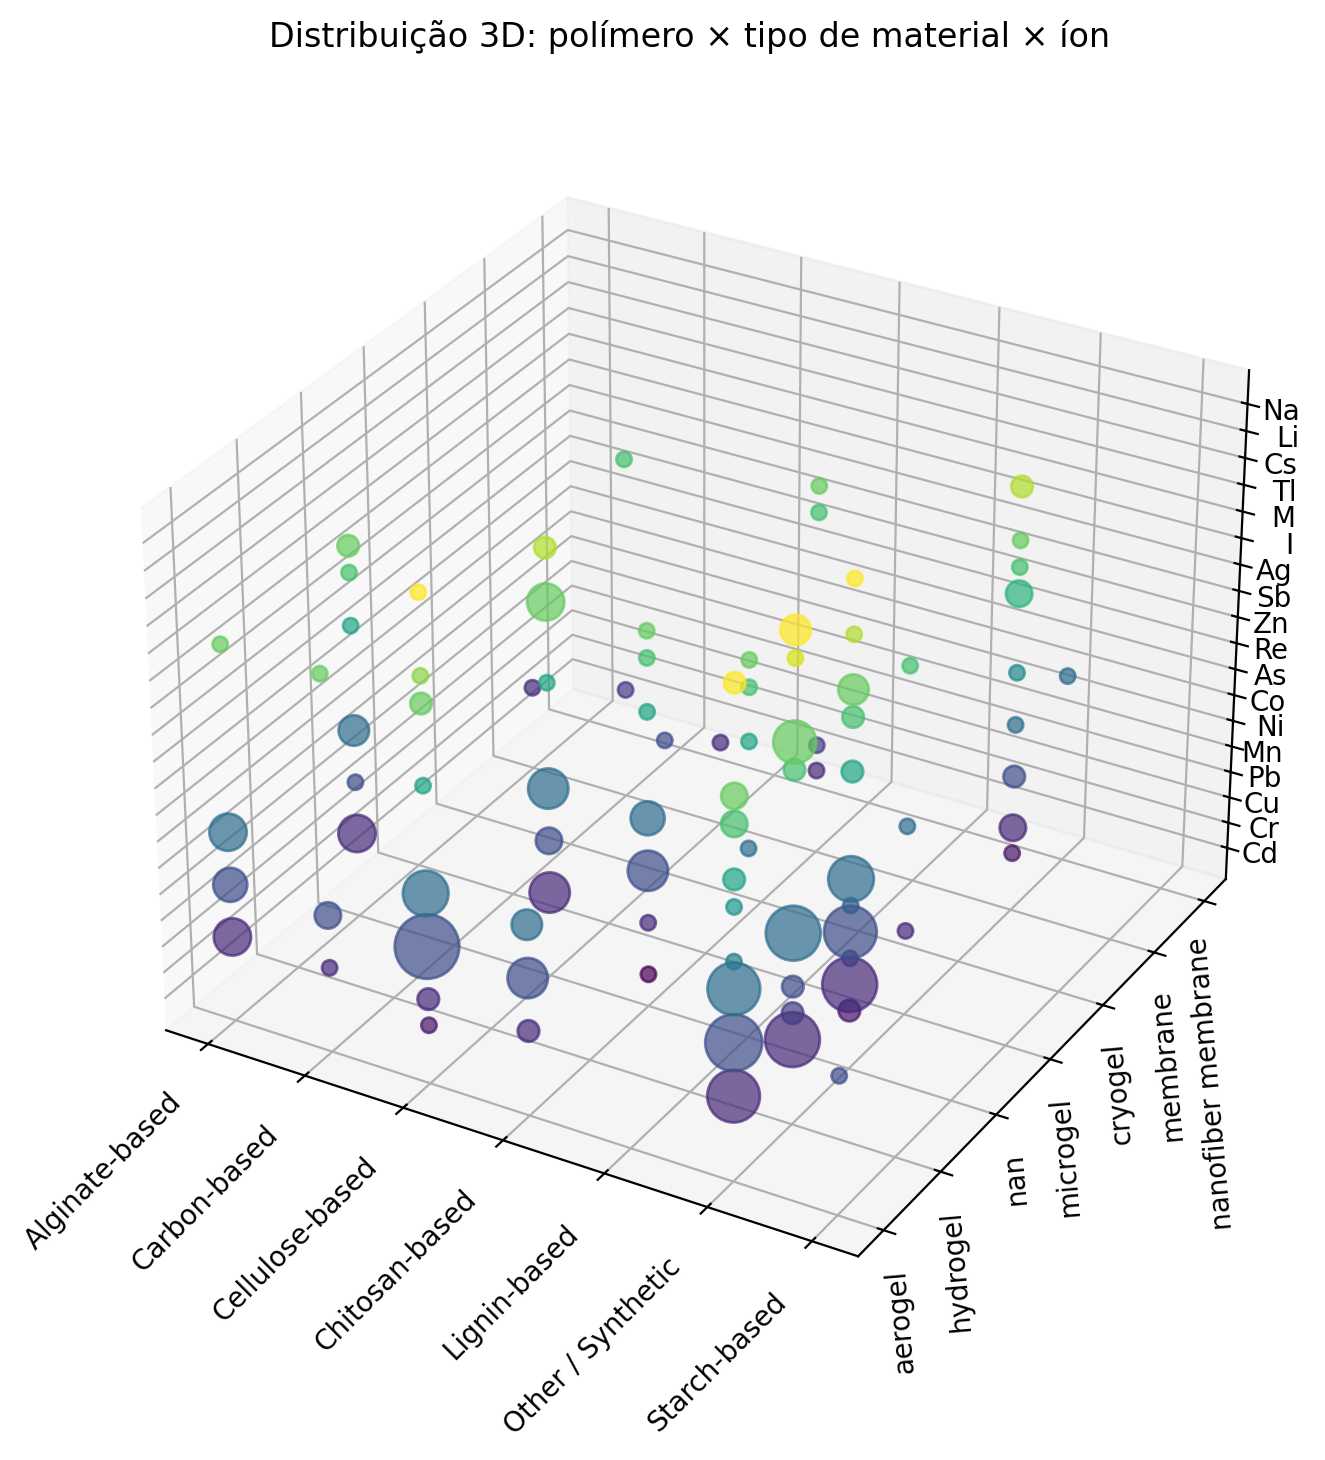

In [17]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12,8), dpi=200)
ax = fig.add_subplot(111, projection='3d')

# Converter categorias em códigos numéricos
x = combo_counts['polymer_group'].astype('category').cat.codes
y = combo_counts['material type'].astype('category').cat.codes
z = combo_counts['ion'].astype('category').cat.codes
sizes = combo_counts['count'] * 30  # escala do tamanho

ax.scatter(x, y, z, s=sizes, c=z, cmap='viridis', alpha=0.7)

# Rótulos dos eixos
# ax.set_xlabel('Polymer group')
# ax.set_ylabel('Material type')
# ax.set_zlabel('Ion')

# Mapear ticks de volta aos nomes
ax.set_xticks(range(len(combo_counts['polymer_group'].unique())))
ax.set_xticklabels(combo_counts['polymer_group'].unique(), rotation=45, ha='right')

ax.set_yticks(range(len(combo_counts['material type'].unique())))
ax.set_yticklabels(combo_counts['material type'].unique(), rotation=95, ha='right')

ax.set_zticks(range(len(combo_counts['ion'].unique())))
ax.set_zticklabels(combo_counts['ion'].unique(), rotation=0, ha='right')

plt.title("Distribuição 3D: polímero × tipo de material × íon", pad=20)
plt.tight_layout()
plt.show()


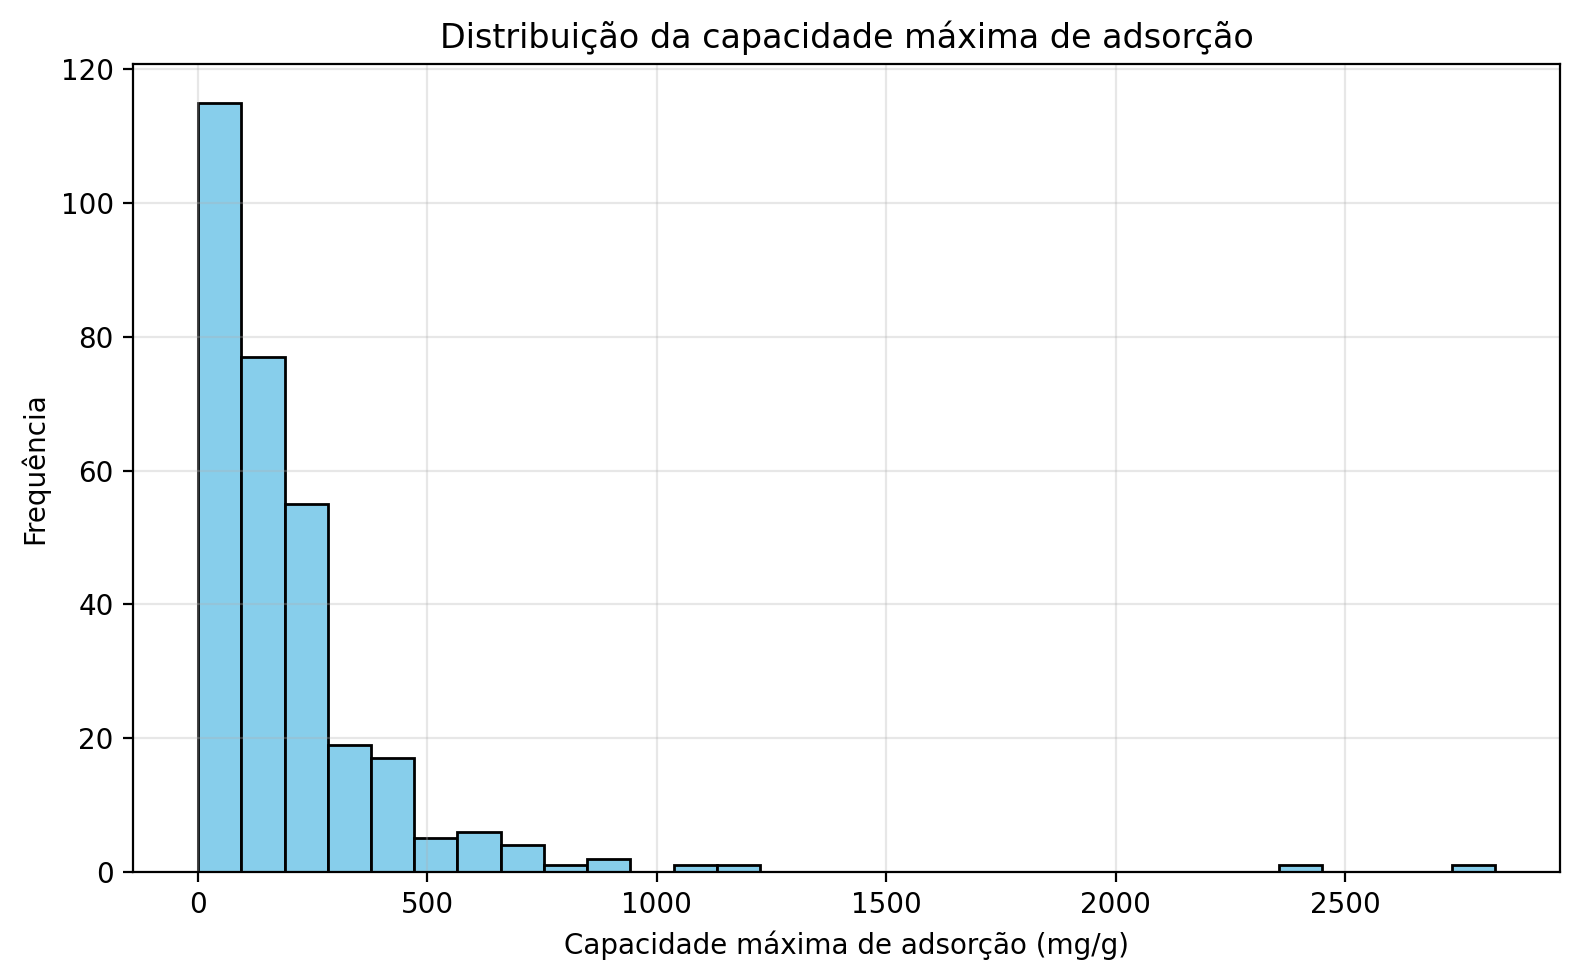

In [18]:
plt.figure(figsize=(8,5), dpi=200)
plt.hist(df['value'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Capacidade máxima de adsorção (mg/g)')
plt.ylabel('Frequência')
plt.title('Distribuição da capacidade máxima de adsorção')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()